In [1]:
import pandas as pd
import numpy as np
import quantutils.regression_utils as qu
import quantutils.general_utils as genutils
from quantutils.general_utils import get_df_regime_label
import quantutils.streamlit_utils as stutils
from functools import partial
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objs as go
from copy import deepcopy
from plotly.subplots import make_subplots
from pathlib import Path
import os
from functools import partial
%load_ext autoreload
%autoreload 2

In [2]:
model = genutils.load_object('test.pkl', 'C:/Users/Wazir/Documents/wazewww/MLP/RegressionTools/Models/CPIUSAMonthly_pct_change_3period/')

In [3]:
df_X = deepcopy(model['X_dataframes'])
df_X = df_X.dropna().iloc[0][0]
fitted_model = deepcopy(model['fitted_models']).dropna().iloc[0][0]


In [4]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import LinearRegression
def forecast_ar4(series, t, ar_lag):
    # Fit an AR(4) model
    model = AutoReg(series, lags=ar_lag)
    model_fit = model.fit()

    # Forecast 't' time steps
    forecast = model_fit.predict(start=len(series), end=len(series) + t - 1)
    return forecast


def get_naive_forecast(df_X, fitted_model, ar_lag, forecast_horizon=10):
    df_Xc = df_X.copy()
    partial_ar4 = partial(forecast_ar4, t=forecast_horizon, ar_lag=ar_lag)
    df_X_extrapolated = df_X.apply(partial_ar4, axis=0)
    one_step_pred = fitted_model.predict(df_X.iloc[-2:])[-1]
    forecast_indx = df_X_extrapolated.index
    predict_extrapolate = pd.Series(fitted_model.predict(df_X_extrapolated), index=forecast_indx, name='target_extrapolate')
    predict_extrapolate.loc[df_X.index[-1]] = one_step_pred
    return df_X_extrapolated, predict_extrapolate.sort_index()



df_X_extrapolated, predict_extrapolate = get_naive_forecast(df_X, fitted_model, 4, 20)
df_X.tail()

0.011072604205515191


c:\Users\Wazir\anaconda3\envs\regtool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Wazir\anaconda3\envs\regtool\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\Users\Wazir\anaconda3\envs\regtool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Wazir\anaconda3\envs\regtool\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a

,5yTreasuryMonthly_diff_3period_natlag1,PPIPassenger_CarsMonthly_pct_change_3period_natlag1
Date,,
2007-06-30,-0.04,-0.003962
2007-07-31,0.55,-0.003157
2007-08-31,0.29,0.007183
2007-09-30,-0.24,0.004773
2007-10-31,-0.83,-0.020586


<Axes: >

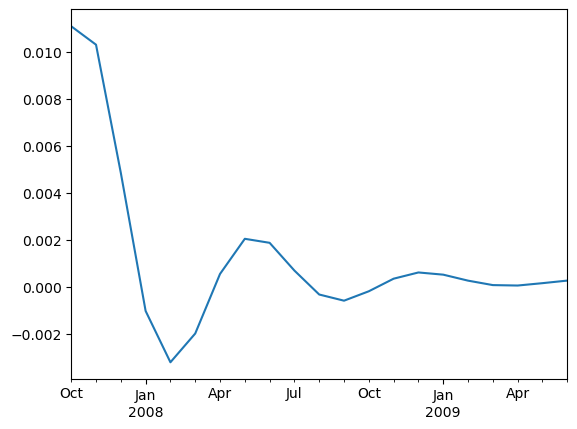

In [5]:
predict_extrapolate.plot()

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def generate_stats_table(regression_streamlit_state):
    y_pred = regression_streamlit_state['df_coefs_dict']['predictions'].dropna()
    y_true = regression_streamlit_state['df_transformed_lag'][regression_streamlit_state['selected_target']]
    stats = [('r2', col, r2_score(y_true.loc[y_pred.index].values, y_pred[col])) for col in y_pred.columns]  + \
        [('mse', col, mean_squared_error(y_true.loc[y_pred.index].values, y_pred[col])) for col in y_pred.columns] + \
        [('mae', col, mean_absolute_error(y_true.loc[y_pred.index].values, y_pred[col])) for col in y_pred.columns] + \
        [('corr', col, np.corrcoef(y_true.loc[y_pred.index].values, y_pred[col].values)[0][1]) for col in y_pred.columns]
        
    df_stats = pd.DataFrame(stats, columns=['metrics', 'model', 'value'])
    return df_stats


In [9]:
model['df_transformed_lag']

,PPIPassenger_CarsMonthly,ManheimUsedVehicleMonthly,CPIUNSAMonthly,CPIUNSAMonthly_pct_change_3period,PPIPassenger_CarsMonthly_pct_change_3period,ManheimUsedVehicleMonthly_pct_change_3period,PPIPassenger_CarsMonthly_natlag1,ManheimUsedVehicleMonthly_natlag1,CPIUNSAMonthly_natlag1,CPIUNSAMonthly_pct_change_3period_natlag1,PPIPassenger_CarsMonthly_pct_change_3period_natlag1,ManheimUsedVehicleMonthly_pct_change_3period_natlag1
Date,,,,,,,,,,,,
2000-01-31,133.400,109.1,153.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,132.700,109.5,152.998,NaN,NaN,NaN,133.400,109.1,153.900,NaN,NaN,NaN
2000-03-31,132.700,110.1,152.975,NaN,NaN,NaN,132.700,109.5,152.998,NaN,NaN,NaN
2000-04-30,132.800,109.8,153.975,0.000487,-0.004498,0.006416,132.700,110.1,152.975,NaN,NaN,NaN
2000-05-31,133.500,110.2,155.385,0.015602,0.006029,0.006393,132.800,109.8,153.975,0.000487,-0.004498,0.006416
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,139.972,215.1,202.007,0.091947,-0.018085,-0.096598,141.025,224.5,199.576,0.089145,-0.014645,-0.042644
2023-07-31,140.277,211.7,201.624,0.042556,-0.008040,-0.082756,139.972,215.1,202.007,0.091947,-0.018085,-0.096598
2023-08-31,140.669,212.2,198.768,-0.004049,-0.002524,-0.054788,140.277,211.7,201.624,0.042556,-0.008040,-0.082756


In [26]:
models = [model, model2]
'''
- prediction over time
- scatter plot
- weighting scheme (hard to implement)
- correlation between models (both error and residuals)
- ranking of models
'''
TARGET = 'CPI-U_SA_M'
def model_comparison(models_list, target_variable_index_name, prediction_agg_function='mean', shift=1):
    target_index = deepcopy(models_list[0]['df_transformed_lag'][target_variable_index_name])
    df_preds_mega = []
    df_residuals_mega = []
    sharpes = []
    df_stats_mega = []
    for model in models_list:
        df_predictions = deepcopy(model['df_coefs_dict']['predictions']).dropna()
        df_residuals = deepcopy(model['df_coefs_dict']['residuals'].dropna())
        df_stats = generate_stats_table(model).set_index('metrics')
        stats_agg = df_stats.select_dtypes('number').groupby('metrics').mean()
        pred_agg = df_predictions.mean(axis=1)
        residuals_agg = df_residuals.mean(axis=1)
        pred_agg.name = model['name']
        residuals_agg.name = model['name']
        pnl = pred_agg.shift(shift) * target_index.pct_change()
        sharpe = (pnl.mean()/pnl.std())
        stats_agg.loc[len(stats_agg)] = (sharpe)
        stats_agg.index = list(stats_agg.index[:-1]) + ['sharpe']
        stats_agg.name = model['name']
        df_preds_mega.append(pred_agg)
        df_residuals_mega.append(residuals_agg)
        df_stats_mega.append(stats_agg)
        sharpes.append(sharpe)
    
    df_preds_mega = pd.concat(df_preds_mega, axis=1)
    df_residuals_mega = pd.concat(df_residuals_mega, axis=1)
    df_stats_mega = pd.concat(df_stats_mega, axis=1)
    df_stats_mega.columns = [model['name'] for model in models_list]
    df_preds_mega['target'] = model['df_transformed_lag'][model['selected_target']]
    return df_preds_mega.dropna(), df_residuals_mega.dropna(), df_stats_mega



df_preds_mega, df_residuals_mega, df_stats_mega = model_comparison(models, 'CPIUNSAMonthly')

In [29]:
model['selected_x_variables']

['PPIPassenger_CarsMonthly_pct_change_3period_natlag1',
 'ManheimUsedVehicleMonthly_pct_change_3period_natlag1']

In [30]:
model2['selected_x_variables']

['5yTreasuryMonthly_diff_3period_natlag1',
 'PPIAutomotiveMonthly_pct_change_3period_natlag1',
 'PPIPassenger_CarsMonthly_pct_change_3period_natlag1',
 'CPIUNSAMonthly_pct_change_3period_natlag1']

<Axes: xlabel='Date'>

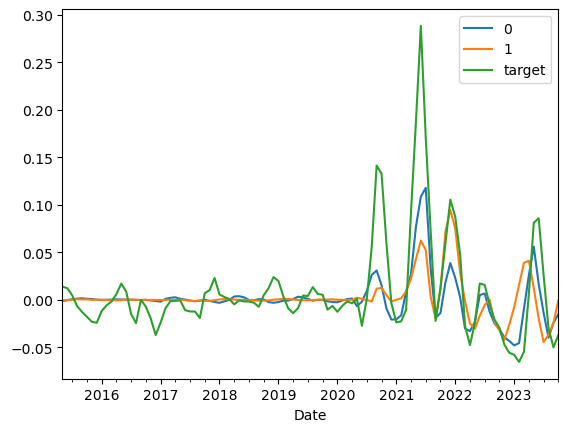

In [160]:
df_preds_mega.plot()

In [152]:
df_preds_mega.describe()

,0,1,target
count,102.000000,102.000000,102.000000
mean,0.000857,0.002270,0.008714
std,0.024093,0.020811,0.052194
min,-0.048190,-0.044599,-0.065551
25%,-0.002580,-0.000763,-0.014927
50%,-0.000233,-0.000212,-0.001915
75%,0.001793,0.000356,0.012093
max,0.117726,0.094469,0.288217


In [153]:
df_residuals_mega.corr()

,0,1
0,1.000000,0.909474
1,0.909474,1.000000


In [135]:
df_stats_mega

,value,value
corr,0.860141,0.558157
mae,0.020556,0.021150
mse,0.001191,0.001390
r2,0.558430,0.251603
sharpe,0.273850,0.218374


In [112]:
df_residuals_mega

,0,1
Date,,
2009-10-31,NaN,-0.079585
2009-11-30,NaN,-0.085513
2009-12-31,NaN,-0.091385
2010-01-31,NaN,-0.078874
2010-02-28,NaN,-0.055002
...,...,...
2023-06-30,-0.069393,-0.105732
2023-07-31,-0.039483,-0.070158
2023-08-31,-0.010120,-0.006969


In [117]:
def plotly_ranking(df_ranks, title):
    df_ranksc = df_ranks.copy().dropna()
    fig = go.Figure()
    # Add a line to the figure for each series
    for column in df_ranksc.columns:
        fig.add_trace(go.Scatter(x=df_ranksc.index, y=df_ranksc[column], mode='lines+markers', name=column))

    # Update the layout
    fig.update_layout(
        title=title,
        xaxis_title='Time',
        yaxis_title='Ranking',
        yaxis=dict(
            autorange='reversed',  # Reverse y-axis so that rank 1 appears at the top
            tickmode='array',
            tickvals=np.arange(1, len(df_ranksc.columns) + 1),
            ticktext=[f"Rank {i}" for i in range(1, len(df_ranksc.columns) + 1)]
        ),
        template='plotly_white'
    )

    return fig

plotly_ranking(df_residuals_mega.abs().rolling(5).mean().rank(ascending=True, axis=1), 'plot')

In [115]:
df_residuals_mega.abs().rolling(5).mean().rank(ascending=True, axis=1)

,0,1
Date,,
2009-10-31,NaN,NaN
2009-11-30,NaN,NaN
2009-12-31,NaN,NaN
2010-01-31,NaN,NaN
2010-02-28,NaN,1.0
...,...,...
2023-06-30,1.0,2.0
2023-07-31,1.0,2.0
2023-08-31,1.0,2.0


In [19]:
target = 'CPI-U_SA_M'
df_variables = deepcopy(model['df_transformed_lag'])
df_variables['CPI-U_SA_M']

Date
2000-01-31    153.900
2000-02-29    153.000
2000-03-31    153.000
2000-04-30    154.000
2000-05-31    155.400
               ...   
2023-06-30    198.746
2023-07-31    196.086
2023-08-31    193.671
2023-09-30    188.772
2023-10-31    188.772
Name: CPI-U_SA_M, Length: 286, dtype: float64

In [91]:
model['df_coefs_dict']['residuals']

,residuals_70,residuals_90
Date,,
2000-01-31,NaN,NaN
2000-02-29,NaN,NaN
2000-03-31,NaN,NaN
2000-04-30,NaN,NaN
2000-05-31,NaN,NaN
...,...,...
2023-06-30,-0.069390,-0.069397
2023-07-31,-0.039565,-0.039401
2023-08-31,-0.010217,-0.010024


In [49]:
df_variables.filter(regex='PPI_Passe')

,PPI_Passenger_Cars_M,PPI_Passenger_Cars_M_pct_change_3period,PPI_Passenger_Cars_M_natlag1,PPI_Passenger_Cars_M_pct_change_3period_natlag1
Date,,,,
2000-01-31,133.400,NaN,NaN,NaN
2000-02-29,132.700,NaN,133.400,NaN
2000-03-31,132.700,NaN,132.700,NaN
2000-04-30,132.800,-0.004498,132.700,NaN
2000-05-31,133.500,0.006029,132.800,-0.004498
...,...,...,...,...
2023-06-30,139.972,-0.018085,141.025,-0.014645
2023-07-31,140.277,-0.008040,139.972,-0.018085
2023-08-31,140.669,-0.002524,140.277,-0.008040


In [85]:
model['selected_x_variables']

['PPI_Passenger_Cars_M_pct_change_3period_natlag1',
 'PPI_Used_Vehicles_M_pct_change_3period_natlag1']

In [20]:
df_predictions = deepcopy(model['df_coefs_dict']['predictions']).dropna()
df_predictions

,predictions_70,predictions_90
Date,,
2015-05-31,-0.002189,-0.000983
2015-06-30,-0.000596,-0.000205
2015-07-31,0.000732,0.000211
2015-08-31,0.001821,0.000361
2015-09-30,0.002596,0.000346
...,...,...
2023-06-30,0.016298,0.016291
2023-07-31,-0.014005,-0.013841
2023-08-31,-0.040145,-0.039952


In [29]:
import matplotlib.pyplot as plt

<Axes: xlabel='Date'>

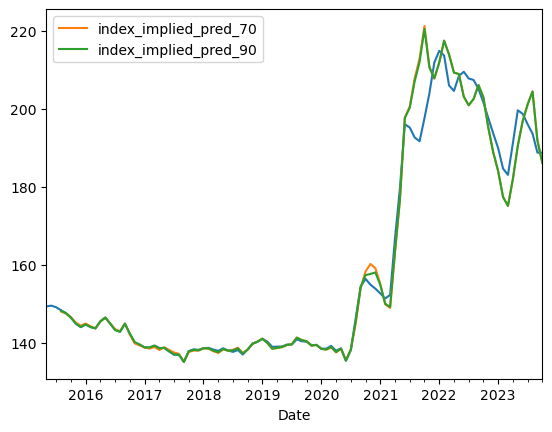

In [42]:
df_predictions_and_target = pd.concat([df_predictions, df_variables[target]], axis=1).dropna()
shift = 3
df_predictions_and_target['target'] = df_variables[model['selected_target']]
df_predictions_and_target['index_implied_pred_70'] = df_predictions_and_target['CPI-U_SA_M']*(1+df_predictions_and_target['predictions_70']).shift(shift)
df_predictions_and_target['index_implied_pred_90'] = df_predictions_and_target['CPI-U_SA_M']*(1+df_predictions_and_target['predictions_90']).shift(shift)
f = plt.figure()
df_predictions_and_target[target].plot(ax=f.gca())
df_predictions_and_target[['index_implied_pred_70', 'index_implied_pred_90']].plot(ax=f.gca())


<Axes: xlabel='Date'>

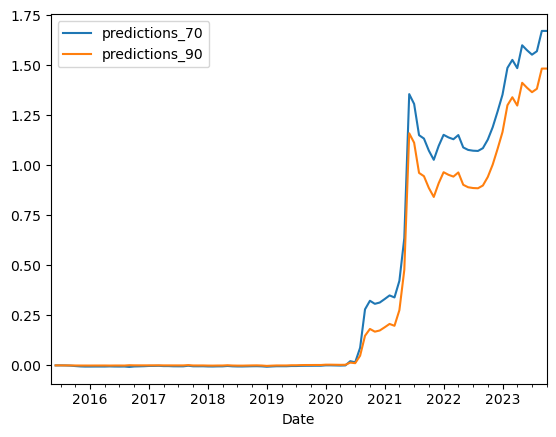

In [149]:
df_predictions_and_target.filter(regex='predi').shift(1).mul(df_predictions_and_target[target].pct_change()*100, axis='index').cumsum().plot()


<Axes: xlabel='Date'>

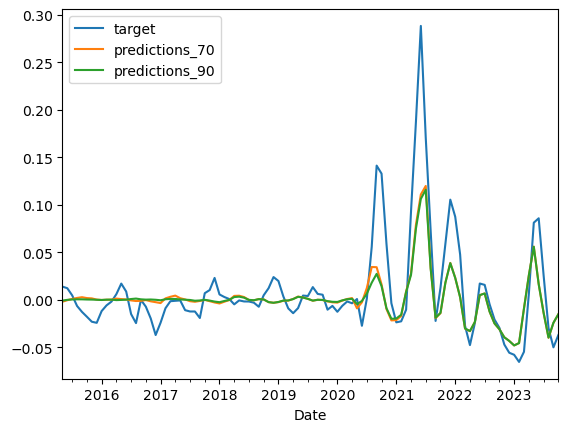

In [45]:
df_predictions_and_target[['target', 'predictions_70', 'predictions_90']].plot()

<Axes: xlabel='Date'>

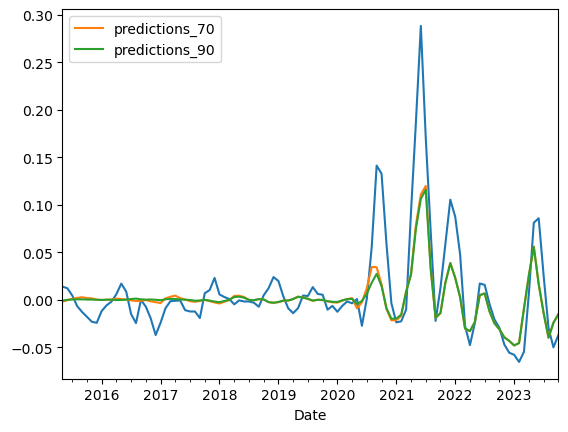

In [47]:
f = plt.figure()
df_predictions_and_target['target'].plot(ax=f.gca())
df_predictions_and_target[['predictions_70', 'predictions_90']].plot(ax=f.gca())

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [84]:
y_pred = model['df_coefs_dict']['predictions'].dropna()
y_true = model['df_transformed_lag'][model['selected_target']]
stats = [('r2', col, r2_score(y_true.loc[y_pred.index].values, y_pred[col])) for col in y_pred.columns]  + \
    [('mse', col, mean_squared_error(y_true.loc[y_pred.index].values, y_pred[col])) for col in y_pred.columns] + \
    [('mae', col, mean_absolute_error(y_true.loc[y_pred.index].values, y_pred[col])) for col in y_pred.columns] + \
    [('corr', col, np.corrcoef(y_true.loc[y_pred.index].values, y_pred[col].values)[0][1]) for col in y_pred.columns]
    
df_stats = pd.DataFrame(stats, columns=['metrics', 'model', 'value'])
df_stats

,metrics,model,value
0,r2,predictions_70,0.569746
1,r2,predictions_90,0.547114
2,mse,predictions_70,0.001161
3,mse,predictions_90,0.001222
4,mae,predictions_70,0.020426
5,mae,predictions_90,0.020685
6,corr,predictions_70,0.863449
7,corr,predictions_90,0.856833


In [79]:
np.corrcoef(y_true.loc[y_pred.index].values, y_pred['predictions_70'].values)[0][1]

0.8634494374841277

In [ ]:
np.correlate()